In [15]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

2025-11-26 17:06:26,662	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.7.2 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [80]:
import geopandas as gpd

# import the covariates (predictors)
gdf = gpd.read_file(r"C:\Users\sbett\Downloads\predictors_sel_v1.3.gpkg")
X = gdf.drop(columns=['geometry'])

# import the richness values (outcome)
df = pd.read_csv(r"C:\Users\sbett\Downloads\div_indices_v1.0_sel_v1.1.csv", sep=';')
Y = df['R'].values

# import the bathymetry values (treatment)
T = X['gravity_mean_log'].values.reshape(-1, 1)

columns_to_keep = ['cop_chl_month_mean_log', 'shore_dist_m_weight_log', 'canyon_dist_m_weight_log', 'port_dist_m_weight', 'bathy_mean']

X = X.loc[:, columns_to_keep] # keep only selected columns for the covariates

# Train–test split (for illustration)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=0
)

Y_train = Y_train.ravel()

In [81]:
# Nuisance models for outcome and treatment
model_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=0)
model_t = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=0)

# Causal forest DML for continuous treatment
cf = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=False,
    n_estimators=500,
    min_samples_leaf=10,
    random_state=0
)

cf.fit(Y_train, T_train, X=X_train)

# Marginal effect of depth at each test point (CATE wrt depth)
t_effect_test = cf.effect(X_test)  # shape (n_test, 1)

print(t_effect_test[:10])

c:\Users\sbett\anaconda3\envs\hls\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Returns
c:\Users\sbett\anaconda3\envs\hls\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Returns


[-1.34771003 -1.6429249  -2.6970592  -2.53946769 -1.22575282  1.48865908
 -1.11833968 -1.47519765 -1.95541012 -3.0570518 ]


In [82]:
t_eff = cf.effect(X_test)
np.mean(t_eff), np.median(t_eff), np.quantile(t_eff, [0.1, 0.5, 0.9])

(-1.0879547824333964,
 -1.340928814391775,
 array([-2.38865868, -1.34092881,  0.44164795]))

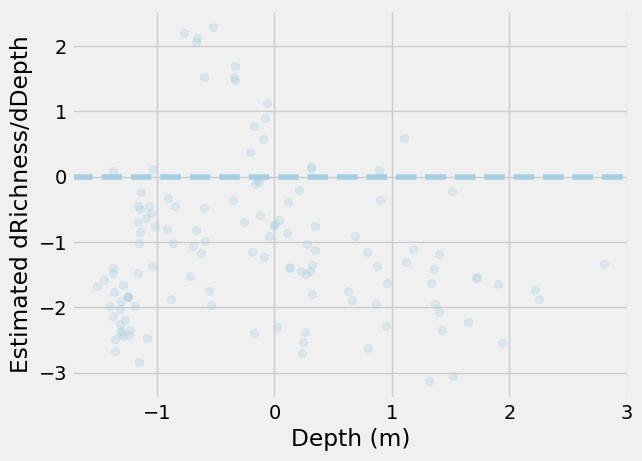

In [83]:
import matplotlib.pyplot as plt

depth_test = T_test.ravel()  # depths for the same X_test points

plt.scatter(depth_test, t_eff, alpha=0.3)
plt.xlabel("Depth (m)")
plt.ylabel("Estimated dRichness/dDepth")
plt.axhline(0, linestyle="--")
plt.show()

In [84]:
q = np.quantile(depth_test, [0.25, 0.5, 0.75])
groups = [
    depth_test < q[0],
    (depth_test >= q[0]) & (depth_test < q[1]),
    (depth_test >= q[1]) & (depth_test < q[2]),
    depth_test >= q[2],
]

for i, g in enumerate(groups, start=1):
    if np.sum(g) == 0:
        continue
    print(f"Depth quartile {i}: n={np.sum(g)}, mean effect={np.mean(t_eff[g]):.3f}")

Depth quartile 1: n=32, mean effect=-1.706
Depth quartile 2: n=32, mean effect=-0.226
Depth quartile 3: n=32, mean effect=-0.864
Depth quartile 4: n=32, mean effect=-1.556


In [85]:
print(columns_to_keep)

['cop_chl_month_mean_log', 'shore_dist_m_weight_log', 'canyon_dist_m_weight_log', 'port_dist_m_weight', 'bathy_mean']


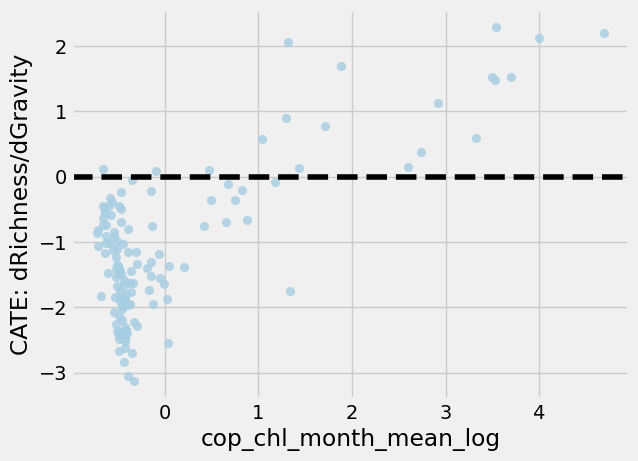

In [88]:
import matplotlib.pyplot as plt
import numpy as np

covariate = "cop_chl_month_mean_log"

pp = X_test[covariate]

plt.scatter(pp, t_eff, alpha=0.8)
plt.xlabel(covariate)
plt.ylabel("CATE: dRichness/dGravity")
plt.axhline(0, linestyle="--", color="k")
plt.show()

In [89]:
t_eff = cf.effect(X_test)   # or X_train or whole dataset
ate = t_eff.mean()
print("ATE (depth):", ate)

# std and 95% CI
std_ate = t_eff.std()
lower = ate - 1.96 * std_ate / np.sqrt(len(t_eff))
upper = ate + 1.96 * std_ate / np.sqrt(len(t_eff))
print("95% CI for ATE (depth):", (lower, upper))

ATE (depth): -1.0879547824333962
95% CI for ATE (depth): (-1.28950127519129, -0.8864082896755023)
